In [1]:
# Load library/package
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import shapiro

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Statmodels
import statsmodels
import statsmodels.api as sm

In [2]:
!pip install pandas matplotlib seaborn xgboost scikit_learn

In [3]:
# connect colab ke g drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Memuat data train dan test
data_train = pd.read_csv("/content/gdrive/MyDrive/2. Regression - Anindita Novianti/Dataset/Train_sales.csv")
data_test = pd.read_csv("/content/gdrive/MyDrive/2. Regression - Anindita Novianti/Dataset/Test_databigsales.csv")

data_train.head()
data_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


**Exploratory Data Analysis (EDA)**

**Data Train**

In [5]:
# Mendapatkan informasi dari data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Pre - Processing - Data Train**

In [6]:
# Mengubah Missing Values dengan Mean dan Mode
data_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
data_train['Item_Weight'].mean()

12.857645184135976

In [8]:
data_train['Item_Weight'].fillna(data_train['Item_Weight'].mean(), inplace=True)

In [9]:
data_train.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
outlet_size_mode = data_train.pivot_table(values='Outlet_Size', columns = 'Outlet_Type', aggfunc=(lambda x:x.mode()))

In [11]:
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [12]:
missing_values_loc = data_train['Outlet_Size'].isnull()

In [13]:
missing_values_loc

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [14]:
data_train.loc[missing_values_loc,'Outlet_Size'] = data_train.loc[missing_values_loc,'Outlet_Type' ].apply(lambda x:outlet_size_mode[x])

In [15]:
data_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

**Data Test**

In [16]:
# Mendapatkan informasi dari data
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


**Pre - Processing - Data Test**

In [17]:
# Mengubah Missing Values dengan Mean dan Mode
data_test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [18]:
data_test['Item_Weight'].mean()

12.695633368756642

In [19]:
data_test['Item_Weight'].fillna(data_test['Item_Weight'].mean(), inplace=True)

In [20]:
data_test.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [21]:
outlet_size_mode = data_test.pivot_table(values='Outlet_Size', columns = 'Outlet_Type', aggfunc=(lambda x:x.mode()))

In [22]:
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [23]:
missing_values_loc = data_test['Outlet_Size'].isnull()

In [24]:
missing_values_loc

0       False
1        True
2        True
3        True
4       False
        ...  
5676    False
5677    False
5678     True
5679     True
5680     True
Name: Outlet_Size, Length: 5681, dtype: bool

In [25]:
data_test.loc[missing_values_loc,'Outlet_Size'] = data_test.loc[missing_values_loc,'Outlet_Type' ].apply(lambda x:outlet_size_mode[x])

In [26]:
data_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [27]:
# Melakukan analisa deskriptif
data_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [28]:
# Melakukan analisa deskriptif
data_test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.245189,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,9.195000,0.027047,94.412000,1987.000000
50%,12.695633,0.054154,141.415400,1999.000000
75%,15.850000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


**Feature Engineering**

<Figure size 600x600 with 0 Axes>

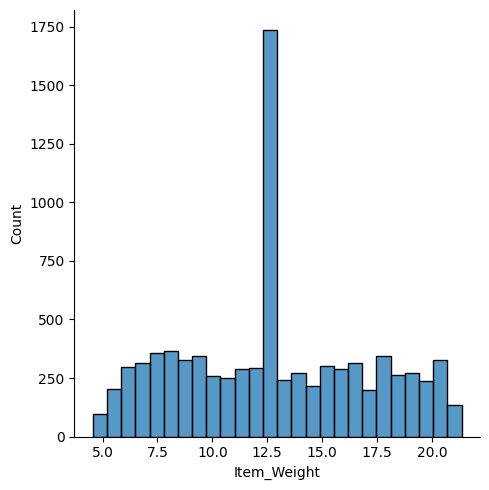

In [29]:
#Data Distribution for Item_Weight Col
plt.figure(figsize=(6,6))
sns.displot(data_train['Item_Weight'])
plt.show()

<Figure size 600x600 with 0 Axes>

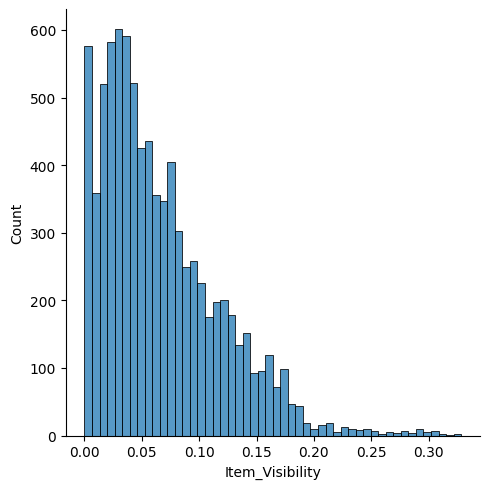

In [30]:
#Data Distribution for Item_Visibility Col
plt.figure(figsize=(6,6))
sns.displot(data_train['Item_Visibility'])
plt.show()

<Figure size 600x600 with 0 Axes>

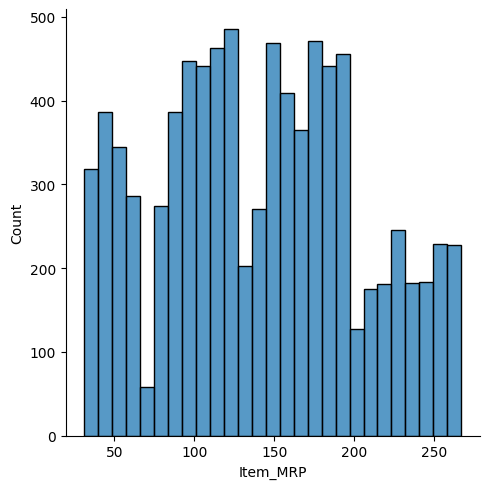

In [31]:
#Data Distribution for Item_MRP Col
plt.figure(figsize=(6,6))
sns.displot(data_train['Item_MRP'])
plt.show()

<Figure size 600x600 with 0 Axes>

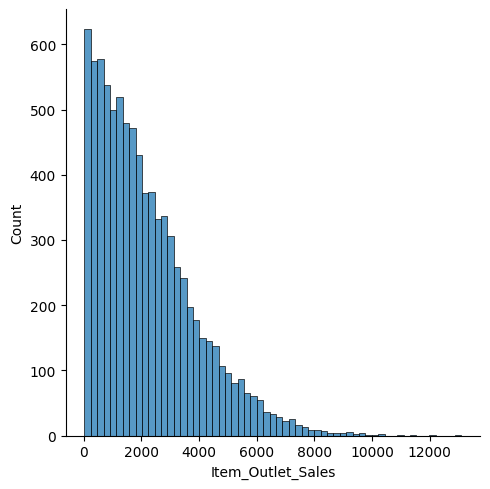

In [32]:
#Data Distribution for Item_Outlet_Sales Col
plt.figure(figsize=(6,6))
sns.displot(data_train['Item_Outlet_Sales'])
plt.show()

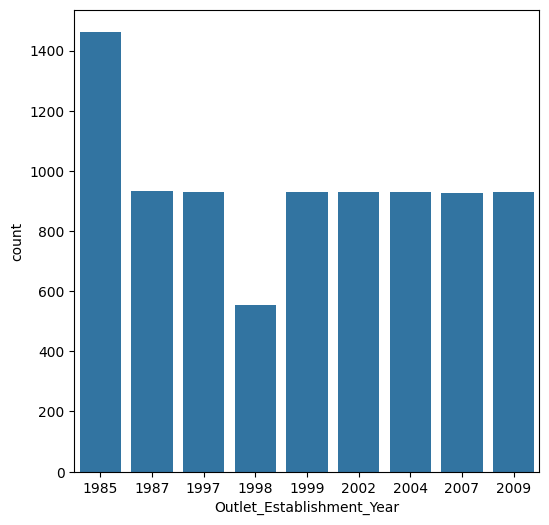

In [33]:
#CountPlot for Item_Outlet_Sales Col
plt.figure(figsize=(6,6))
sns.countplot(x = data_train['Outlet_Establishment_Year'], data=data_train)
plt.show()

In [34]:
data_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


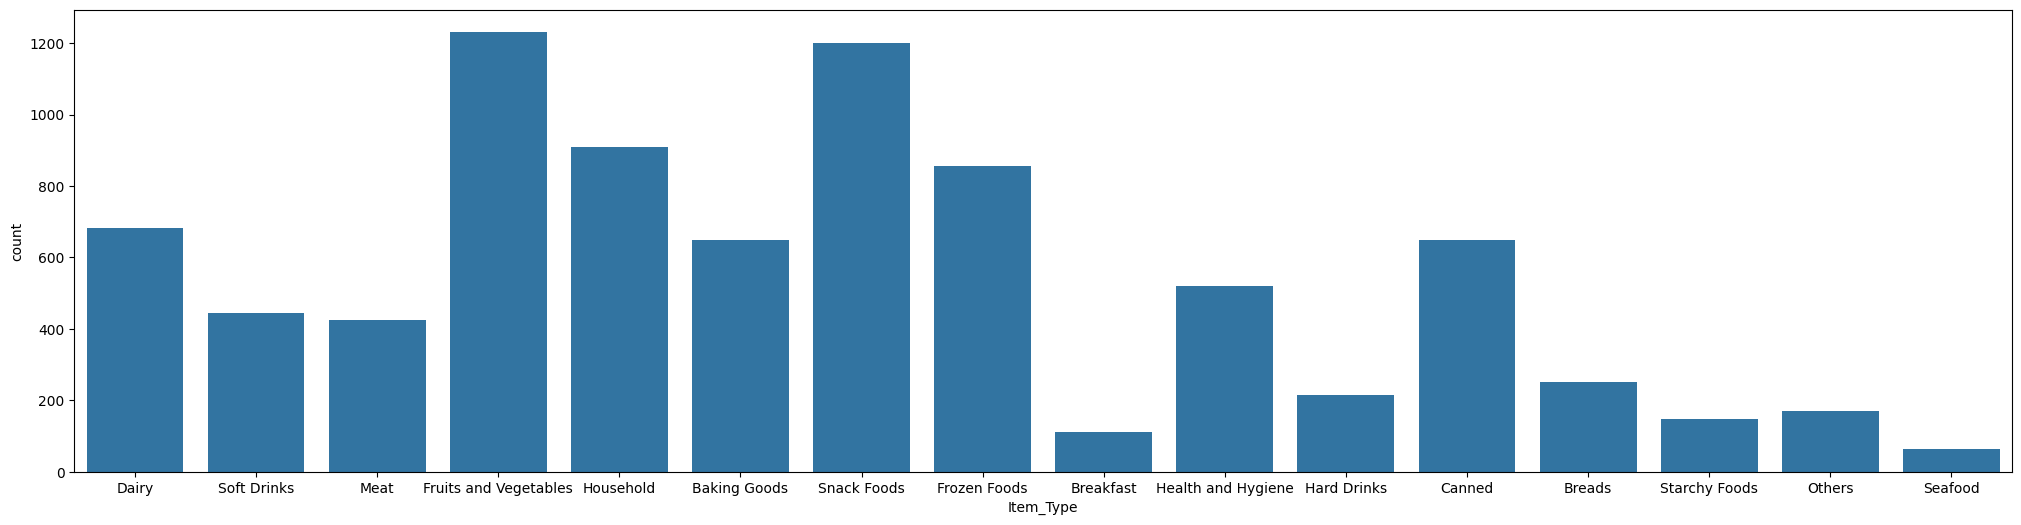

In [35]:
#CountPlot for Item_Outlet_Sales Col
plt.figure(figsize=(25,6))
sns.countplot(x = data_train['Item_Type'], data=data_train)
plt.show()

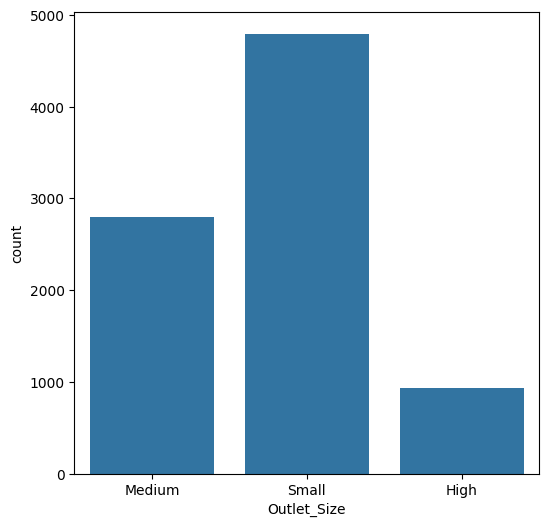

In [36]:
#CountPlot for Item_Outlet_Sales Col
plt.figure(figsize=(6,6))
sns.countplot(x = data_train['Outlet_Size'], data=data_train)
plt.show()

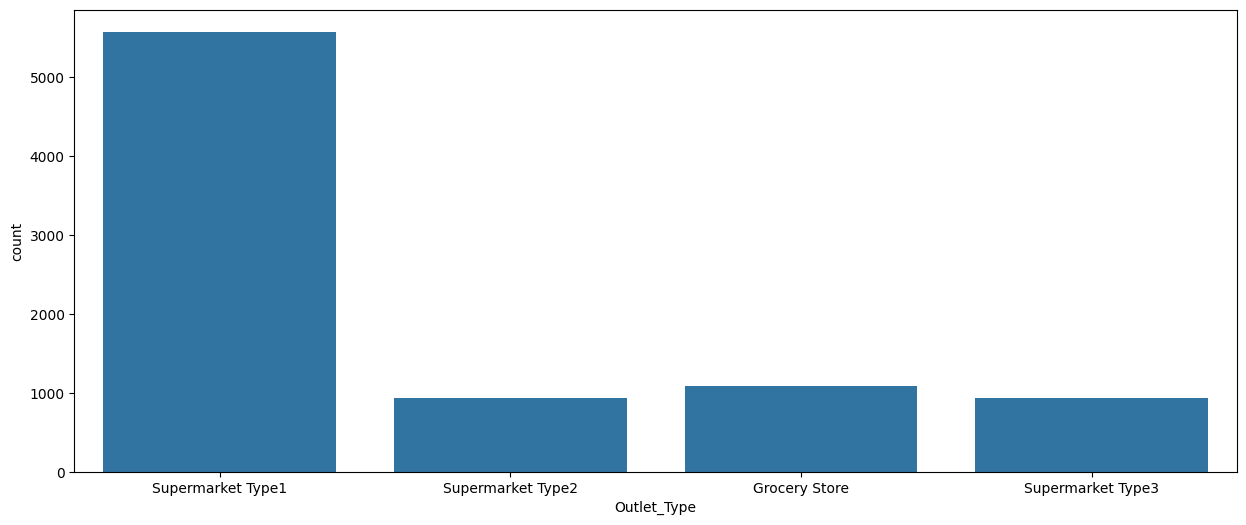

In [37]:
#CountPlot for Item_Outlet_Sales Col
plt.figure(figsize=(15,6))
sns.countplot(x = data_train['Outlet_Type'], data=data_train)
plt.show()

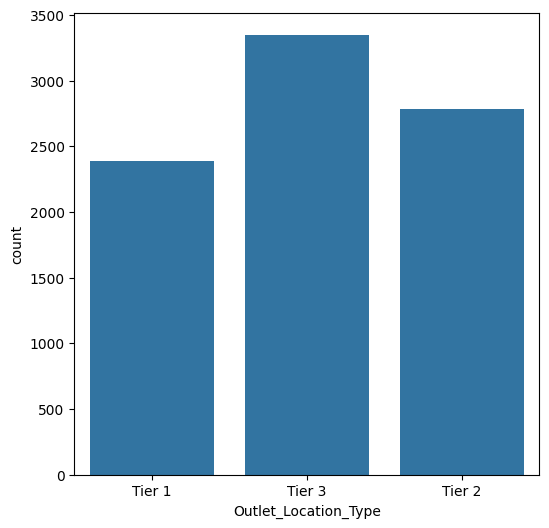

In [38]:
#CountPlot for Item_Outlet_Sales Col
plt.figure(figsize=(6,6))
sns.countplot(x = data_train['Outlet_Location_Type'], data=data_train)
plt.show()

In [39]:
data_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [40]:
data_train.replace({'Item_Fat_Content':{'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [41]:
data_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [42]:
data_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Modelling**

In [43]:
from sklearn.preprocessing import LabelEncoder

In [44]:
encoder = LabelEncoder()

In [45]:
data_train['Item_Identifier'] = encoder.fit_transform(data_train['Item_Identifier'])

data_train['Item_Fat_Content'] = encoder.fit_transform(data_train['Item_Fat_Content'])

data_train['Item_Type'] = encoder.fit_transform(data_train['Item_Type'])

data_train['Outlet_Identifier'] = encoder.fit_transform(data_train['Outlet_Identifier'])

data_train['Outlet_Size'] = encoder.fit_transform(data_train['Outlet_Size'])

data_train['Outlet_Location_Type'] = encoder.fit_transform(data_train['Outlet_Location_Type'])

data_train['Outlet_Type'] = encoder.fit_transform(data_train['Outlet_Type'])

In [46]:
data_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
0    5517
1    3006
Name: count, dtype: int64

In [47]:
x = data_train.drop(columns='Item_Outlet_Sales')
y = data_train['Item_Outlet_Sales']

In [48]:
x

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,156,9.300,0,0.016047,4,249.8092,9,1999,1,0,1
1,8,5.920,1,0.019278,14,48.2692,3,2009,1,2,2
2,662,17.500,0,0.016760,10,141.6180,9,1999,1,0,1
3,1121,19.200,1,0.000000,6,182.0950,0,1998,2,2,0
4,1297,8.930,0,0.000000,9,53.8614,1,1987,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8518,370,6.865,0,0.056783,13,214.5218,1,1987,0,2,1
8519,897,8.380,1,0.046982,0,108.1570,7,2002,2,1,1
8520,1357,10.600,0,0.035186,8,85.1224,6,2004,2,1,1
8521,681,7.210,1,0.145221,13,103.1332,3,2009,1,2,2


In [49]:
y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [51]:
print(x.shape, x_train.shape, x_test.shape)

(8523, 11) (6818, 11) (1705, 11)


In [52]:
print(y.shape, y_train.shape, y_test.shape)

(8523,) (6818,) (1705,)


In [53]:
from xgboost import XGBRegressor

In [54]:
model = XGBRegressor()

In [55]:
#training our model

model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
from sklearn.metrics import r2_score

In [57]:
predictions_train = model.predict(x_train)

In [58]:
r2_score(predictions_train, y_train)

0.8395138420254369

In [59]:
predictions_test = model.predict(x_test)

In [60]:
r2_score(predictions_test, y_test)

0.30333069612193